# Machine Learning Assignment 2
## By: Nikolaos Gournakis
## Student ID: it22023

# Loading the data
#### For the loading of the data I created the class MLProject2Dataset which is a subclass of the Dataset class, this is important so that we can easily use the Dataloader class later on. 


In [1]:
# Imports for MLProject2Dataset
import glob
import os
import PIL.Image
import pandas as pd
import torchvision
from torch.utils.data import Dataset

In [2]:
class MLProject2Dataset(Dataset):
    # I added type-annotations to make the code more readable/usable
    def __init__(self, data_dir: str, metadata_fname='metadata.csv', transform: torchvision.transforms = None):
        self.data_dir = data_dir
        self.transform = transform

        self.df = pd.DataFrame(columns=['image_id', 'path'])

        # Get all files in data_dir
        files = glob.glob(data_dir + '/*/*.jpg')
        # If on windows, replace backslash with forward slash
        # on linux, this does nothing
        files = [file.replace(os.sep, '/') for file in files]
        # The line commented bellow was used for testing on a smaller dataset
        # files = files[:3000]

        # Add all files to dataframe
        for file in files:
            # the `file` is in the format `data_dir/every/sub/directory/image_id.jpg`
            # that's why we split it by `/` and get the last element which will always be
            # `image_id.jpg`. Then just remove the `.jpg` extension
            image_id = file.split('/')[-1].split('.')[0]

            # `file` is the full path to the image, so we just create a local variable for readability
            path = file

            # Add new row to dataframe
            self.df.loc[len(self.df)] = [image_id, path]

        # Add metadata
        self.metadata = pd.read_csv(os.path.join(data_dir, metadata_fname))
        dx_categorical = pd.Categorical(self.metadata['dx'])

        # number_to_label_array is used to convert the prediction from a number back to 
        # "Human Readable" format, this also used to make the confusion matrix have the labels as 
        # cells instead of just numbers.
        # Which are the seven string labels given in the assignment
        self.number_to_label_array = [dx for dx in dx_categorical.categories]

        # dx_categorical.codes is a list of numbers from 0 to 6, which represent the seven labels
        # Effectively, we are converting the seven string labels to a number encoding from 0 to 6
        self.metadata['dx'] = dx_categorical.codes

        # Merge metadata with dataframe
        # This creates a new dataframe with all the columns from both dataframes
        # and merges them where the `image_id` is the same
        self.df = self.df.merge(self.metadata, on='image_id')

        # In the assignment, we are asked for the dataframe to have columns = ['image_id', 'path', 'dx']
        # so we drop the excess columns
        self.df = self.df.drop(columns=["lesion_id", "dx_type", "age", "sex", "localization"])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        image_path = self.df.iloc[idx]['path']

        # Load image
        image = PIL.Image.open(image_path)

        # Change pixel values to float
        # This is not really needed, but I do it just in case
        image = image.convert('RGB')

        # We can convert the image to tensor here or later during the data loading
        # image = torchvision.transforms.ToTensor()(image)

        # Get label
        label = self.df.iloc[idx]['dx']

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# We use this function for the Simple CNN and the Complex CNN
# with different values for M and N,but the rest of the code is the same
def create_transform(M: int, N: int) -> torchvision.transforms:
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize((M, N)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])


# train_net

In [4]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim

# These lists are used to store the loss and accuracy for each print_period
# so that we can plot them later
val_loss = []
train_loss = []
val_accuracy = []
train_accuracy = []

def train_net(model: nn.Module, trainloader: DataLoader, valloader: DataLoader = None, epochs: int = 10,
              optimizer: optim.Optimizer = None, loss: nn.modules.loss = None, device: str = 'cpu',
              print_period: int = 10) -> None:
    # Reset the lists so that we don't append to them if we train the model again / train another model
    global val_loss, train_loss, val_accuracy, train_accuracy
    val_loss = []
    train_loss = []
    val_accuracy = []
    train_accuracy = []
    
    for epoch in range(epochs):
        total = 0
        correct = 0
        running_loss = 0.0

        # batch is the index of the batch, 
        # X is `BatchSize` number of images, y is `BatchSize` number of labels 
        # In my experiments, I used `BatchSize` = 32
        for batch, (X, y) in enumerate(trainloader, 0):
            # Set model to train mode
            model.train()

            # Move the images and labels to the device specified
            X = X.to(device)
            y = y.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(X)

            # If I don't cast y to long, I get an error:
            # RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Char'
            # solution: https://stackoverflow.com/a/71126544/13250408
            current_loss = loss(y_pred, y.long())

            # Backward pass
            current_loss.backward()

            # Update weights
            optimizer.step()

            # Get the total number of images processed so far
            total += y.size(0)
            # Get the number of correct predictions so far
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
            # Get the running loss
            running_loss += current_loss.item()

            if batch % print_period == print_period - 1:
            
                avg_loss = running_loss / print_period
                avg_accuracy = correct / total * 100
                # Append the loss and accuracy for the current print_period
                train_loss.append(avg_loss)
                train_accuracy.append(avg_accuracy)
                # This is equal to `total` but for the validation set
                total_val = 0
                # This is equal to `correct` but for the validation set
                correct_val = 0
                # This is equal to `running_loss` but for the validation set
                running_loss_val = 0.0

                # If we have a validation set, we also want to print the validation loss and accuracy
                # noinspection GrazieInspection
                if valloader is not None:
                    # Set model to evaluation mode
                    model.eval()
                    # We don't want to update the weights, so we disable the gradient calculation
                    with torch.no_grad():
                        # Iterate over the validation set
                        for (X_val, y_val) in valloader:
                            # Move the images and labels to the device specified
                            X_val = X_val.to(device)
                            y_val = y_val.to(device)
                            # Get the predictions
                            y_pred_val = model(X_val)
                            # Get the total number of validation images processed so far
                            total_val += y_val.size(0)
                            # Get the running loss for the validation set
                            running_loss_val += loss(y_pred_val, y_val.long()).item()
                            # Get the number of correct predictions for the validation set
                            correct_val += (y_pred_val.argmax(1) == y_val).type(torch.float).sum().item()

                    # To get the average loss, we divide the running loss by the `print_period`
                    # to do the equivalent for the validation set, we need to do it differently
                    # because we test all of the validation set at once, not in batches
                    # so to get the average loss for the validation set, we divide the running loss
                    # with the total number of batches in the validation set, which is equal to
                    # the length of the validation loader
                    avg_loss_val = running_loss_val / len(valloader)
                    avg_accuracy_val = correct_val / total_val * 100
                    # Append the loss and accuracy for the current print_period
                    val_loss.append(avg_loss_val)
                    val_accuracy.append(avg_accuracy_val)
                    # Print the training loss, training accuracy, validation loss and validation accuracy
                    print(
                        f'[{epoch + 1}, {batch + 1}] loss: {avg_loss} | accuracy: {avg_accuracy:.2f}% |'
                        f' val_loss: {avg_loss_val} | val_accuracy: {avg_accuracy_val:.2f}%')

                # If we don't have a validation set, we only print the training loss and accuracy
                else:
                    print(f'[{epoch + 1}, {batch + 1}] loss: {avg_loss} | accuracy: {avg_accuracy :.4f}%')
                # Reset the running loss, total and correct for the next print_period
                running_loss = 0.0
                total = 0
                correct = 0


# test_net

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def test_net(model: nn.Module, testloader: DataLoader, number_to_label_array:list[str],
             loss: nn.modules.loss = None, device: str = 'cpu',) -> None:
    # Set model to evaluation mode
    model.eval()
    correct = 0
    loss_test = 0.0
    y_trues = []
    y_preds = []
    # We don't want to update the weights, so we disable the gradient calculation
    with torch.no_grad():
        # Iterate over the test set
        for (X, y) in testloader:
            # Move the images and labels to the device specified
            X = X.to(device)
            y = y.to(device)
            # Get the predictions
            y_pred_test = model(X)
            
            y_trues.extend(y.cpu().numpy())
            y_preds.extend(y_pred_test.argmax(1).cpu().numpy())
            # Get the total number of test images processed so far
            loss_test += loss(y_pred_test, y.long())
            # Get the number of correct predictions for the test set
            correct += (y_pred_test.argmax(1) == y).type(torch.float).sum().item()
    # Print the test loss and test accuracy
    print(f"Test loss: {loss_test / len(testloader)} |"
          f" Test accuracy: {correct / len(testloader.dataset) * 100:.2f}% ")
    
    # Create the confusion matrix
    conf_matrix = confusion_matrix(y_trues, y_preds)
    
    # Turn the confusion matrix into a dataframe for easier plotting
    df_cm = pd.DataFrame(conf_matrix, index=number_to_label_array,
                            columns=number_to_label_array)
    
    # Plot the confusion matrix
    sns.heatmap(df_cm, annot=True, fmt='g',cmap='PiYG')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



In [6]:
# Setting the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple CNN

In [7]:
class SimpleConvNN(torch.nn.Module):
    def __init__(self):
        super(SimpleConvNN, self).__init__()
        # In the specification of the assignment, it says that 
        # the images will be resized to [50 x 62] x 3 channels
        # the comments bellow are the output image size after each layer
        self.conv1 = torch.nn.Conv2d(3, 32, 3)  # 48 x 60 x 32
        # MaxPool 2x2 24 x 30 x 32
        self.conv2 = torch.nn.Conv2d(32, 64, 3)  # 22 x 28 x 64
        # MaxPool 2x2 11 x 14 x 64
        self.conv3 = torch.nn.Conv2d(64, 64, 3)  # 9 x 12 x 64
        # MaxPool 2x2 4 x 6 x 64
        self.fc = torch.nn.Linear(4 * 6 * 64, 7)
        self.pool = torch.nn.MaxPool2d(2)

    def forward(self, x):
        # Ordering the layers as given in the assignment
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Now let's train the model and test it

In [8]:
from torchsummary import summary

# Constants from the assignment
M = 50
N = 62
# Create the transforms
dataset_transforms = create_transform(M, N)
# Create the dataset
dataset = MLProject2Dataset(data_dir='data', metadata_fname='metadata.csv', transform=dataset_transforms)
# Split the dataset into train, validation and test
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [.6, .1, .3],
                                                                         generator=torch.Generator().manual_seed(42)
                                                                         )
# Create the dataloaders
BATCH_SIZE = 32
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create the model
model = SimpleConvNN()
model = model.to(device)
# Print the model summary
summary(model, (3, M, N))
# Create the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)
# Create the loss function
loss = nn.CrossEntropyLoss()
# Train the model
train_net(model, trainloader, valloader, epochs=20, optimizer=optimizer, loss=loss, device=device)
# This cell took 38 minutes to run on my machine

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 60]             896
         MaxPool2d-2           [-1, 32, 24, 30]               0
            Conv2d-3           [-1, 64, 22, 28]          18,496
         MaxPool2d-4           [-1, 64, 11, 14]               0
            Conv2d-5            [-1, 64, 9, 12]          36,928
         MaxPool2d-6             [-1, 64, 4, 6]               0
            Linear-7                    [-1, 7]          10,759
Total params: 67,079
Trainable params: 67,079
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 1.32
Params size (MB): 0.26
Estimated Total Size (MB): 1.61
----------------------------------------------------------------
[1, 10] loss: 1.518793785572052 | accuracy: 58.13% | val_loss: 1.2464358545839787 | val_accuracy: 65.13%
[1,

Test loss: 0.7584205269813538 | Test accuracy: 73.74% 


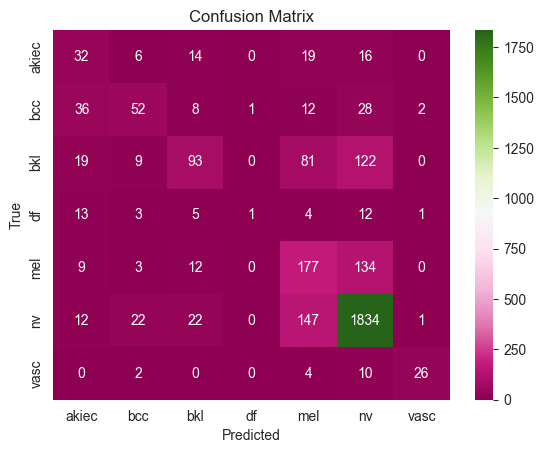

In [33]:
# Get the number_to_label_array so that we can use it later to plot the confusion matrix
simple_number_to_label_array = testloader.dataset.dataset.number_to_label_array
# Test the model
test_net(model, testloader,simple_number_to_label_array, loss=loss, device=device)

## Observations
- We can see that the model has a strong inclination to predict the label `nv` and the label `mel`
This might be because the dataset is imbalanced, as we can see bellow
- The model only predicts `df` once, which again is the least common label in the dataset
- Even though `vasc` is the second least common label, the model does a very good job at predicting it, both precision and recall are very good
- A lot of the predictions of `mel` are actually `nv`, which might mean that either the model is having a hard time distinguishing between the two, or that there are a lot of similarities between the two illnesses
- Even though `bkl` is the second most common label (close with `mel`), the model isn't very good at distinguishing it from `mel` and `nv`.
- We can also see that for `bkl` that has about the same number of samples as `mel`, that when the model was given a `bkl` image, that the predictions are more spread out, whereas for `mel` the predictions are more concentrated on `nv` and `mel`. Again this might strongly suggest that there are a lot of similarities between `mel` and `nv`
- The model's performance on the rest of the labels `akiec`,`bcc`, are very good (recall)

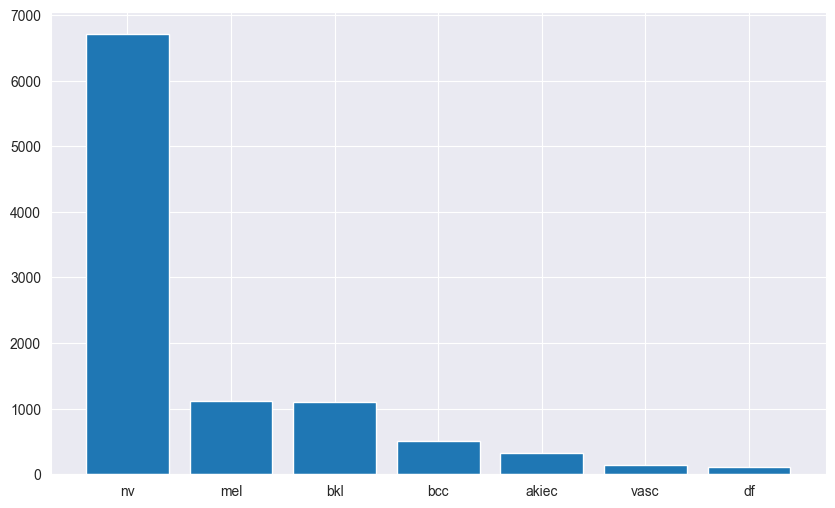

In [10]:
label_counts = dataset.df['dx'].value_counts()
label_counts = [dataset.number_to_label_array[i] for i in label_counts.index]

plt.figure(figsize=(10,6))
plt.bar(label_counts, dataset.df['dx'].value_counts())
plt.show()

## Now let's plot the loss and accuracy

In [11]:
import copy

In [12]:
# Copying the lists so that I don't overwrite them
simple_train_loss = copy.deepcopy(train_loss)
simple_val_loss = copy.deepcopy(val_loss)
simple_train_accuracy = copy.deepcopy(train_accuracy)
simple_val_accuracy = copy.deepcopy(val_accuracy)

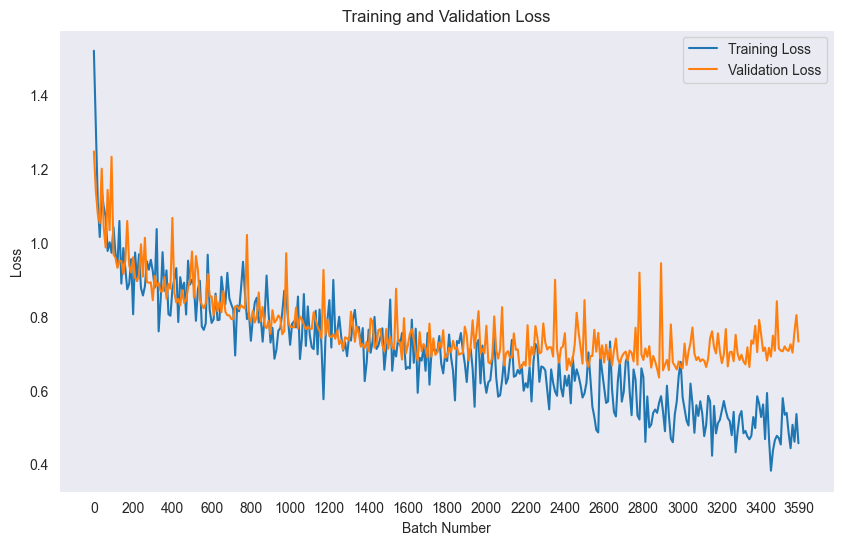

In [13]:
x_axis = list(map(lambda x:x*10,range(len(simple_train_loss))))
plt.figure(figsize=(10,6))
plt.plot(x_axis ,simple_train_loss, label='Training Loss')
plt.plot(x_axis , simple_val_loss,label='Validation Loss')
xticks = np.arange(x_axis[0], x_axis[-1]+1, 200.0)
plt.xticks([*xticks, x_axis[-1]])
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

## Observations
- From the loss plots I can conclude that the model might start to overfit at around 2500 batches, so we might want to stop the training at around that point
- The validation loss and the training loss are very close together, which is a good thing, because the while the model is improving on the training set, it is also improving on the validation set.
- A very negative observation is that both losses are fluctuating a lot, which might mean that the model is "overshooting" the minimum loss, therefore requiring more epochs to train

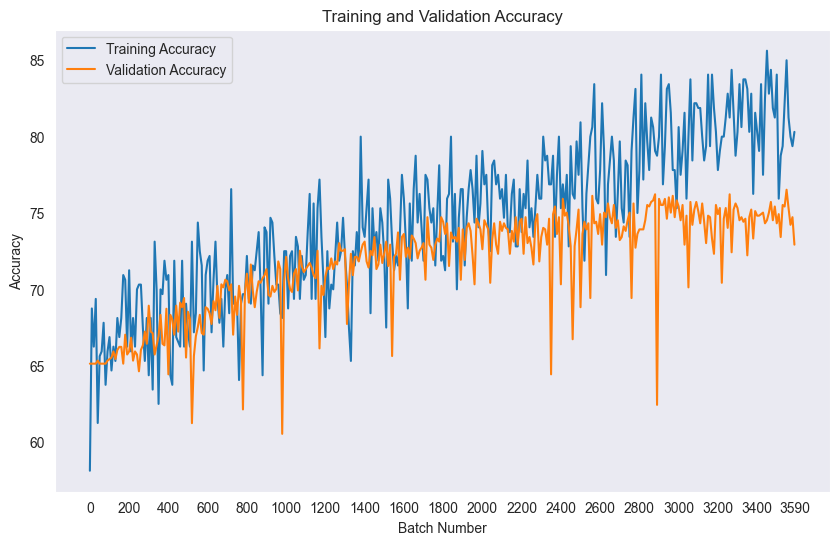

In [14]:
x_axis = list(map(lambda x:x*10,range(len(simple_train_accuracy))))
plt.figure(figsize=(10,6))
plt.plot(x_axis ,simple_train_accuracy, label='Training Accuracy')
plt.plot(x_axis , simple_val_accuracy,label='Validation Accuracy')
xticks = np.arange(x_axis[0], x_axis[-1]+1, 200.0)
plt.xticks([*xticks, x_axis[-1]])
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

## Observations
- From the accuracy plots we can still conclude that the model might start to overfit at around 2500 batches, which is good that both the loss and accuracy plots are showing the same thing
- The accuracy for both the training and validation set are increasing, which is a good thing, because the model is improving on both sets
- We can still see the big fluctuation we noticed on the loss plot before (negative).

# Complex CNN

In [15]:
from torch.nn.functional import relu


class ComplexConvNN(nn.Module):
    def __init__(self):
        super(ComplexConvNN, self).__init__()
        # In the specification of the assignment, it says that 
        # the images should be resized to [100 x 125] x 3 channels
        # the comments bellow are the output image size after each layer
        self.conv1 = nn.Conv2d(3, 32, 3) # 98 x 123 x 32
        self.batchnorm1 = nn.BatchNorm2d(32) # 98 x 123 x 32
        # MaxPool 2x2 49 x 61 x 32
        self.conv2 = nn.Conv2d(32, 64, 3) # 47 x 59 x 64
        self.batchnorm2 = nn.BatchNorm2d(64) # 47 x 59 x 64
        # MaxPool 2x2 23 x 29 x 64
        self.conv3 = nn.Conv2d(64, 128, 3) # 21 x 27 x 128
        self.batchnorm3 = nn.BatchNorm2d(128) # 21 x 27 x 128
        # MaxPool 2x2 10 x 13 x 128
        self.conv4 = nn.Conv2d(128, 256, 3) # 8 x 11 x 256
        self.batchnorm4 = nn.BatchNorm2d(256) # 8 x 11 x 256
        # MaxPool 2x2 4 x 5 x 256
        self.conv5 = nn.Conv2d(256, 512, 3) # 2 x 3 x 512
        self.batchnorm5 = nn.BatchNorm2d(512) # 2 x 3 x 512
        # MaxPool 2x2 1 x 1 x 512
        self.fc = nn.Linear(512, 7)
        self.maxpool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # Ordering the layers as given in the assignment
        x = self.maxpool(self.batchnorm1(relu(self.conv1(x))))
        x = self.maxpool(self.batchnorm2(relu(self.conv2(x))))
        x = self.maxpool(self.batchnorm3(relu(self.conv3(x))))
        x = self.maxpool(self.batchnorm4(relu(self.conv4(x))))
        x = self.maxpool(self.batchnorm5(relu(self.conv5(x))))
        x = nn.functional.adaptive_avg_pool2d(x,(1,1))
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Now let's train the Complex model and test it and see the difference
#### Note: naming everything complex_ so that I don't overwrite the simple model's variables

In [16]:
from torchsummary import summary

# Constants from the assignment
complex_M = 100
complex_N = 125
# Create the transforms
complex_transforms = create_transform(complex_M, complex_N)
# Create the dataset
complex_dataset = MLProject2Dataset(data_dir='data', metadata_fname='metadata.csv', transform=complex_transforms)
# Split the dataset into train, validation and test
complex_train_dataset, complex_val_dataset, complex_test_dataset = torch.utils.data.random_split(
                                                                   complex_dataset,
                                                                   [.6, .1, .3],
                                                                   generator=torch.Generator().manual_seed(42))

# Create the dataloaders
BATCH_SIZE = 32
complex_trainloader = DataLoader(complex_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
complex_valloader = DataLoader(complex_val_dataset, batch_size=BATCH_SIZE, shuffle=True)
complex_testloader = DataLoader(complex_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create the model
complex_model = ComplexConvNN()
complex_model = complex_model.to(device)
# Print the model summary
summary(complex_model, (3, complex_M, complex_N))
# Create the optimizer
complex_optimizer = optim.Adam(complex_model.parameters(), lr=1e-3)
# Create the loss function
complex_loss = nn.CrossEntropyLoss()
# Train the model
train_net(complex_model, complex_trainloader, complex_valloader, epochs=20, optimizer=complex_optimizer,
          loss=complex_loss, device=device)
# This cell took 44 minutes to run on my machine

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 98, 123]             896
       BatchNorm2d-2          [-1, 32, 98, 123]              64
         MaxPool2d-3           [-1, 32, 49, 61]               0
            Conv2d-4           [-1, 64, 47, 59]          18,496
       BatchNorm2d-5           [-1, 64, 47, 59]             128
         MaxPool2d-6           [-1, 64, 23, 29]               0
            Conv2d-7          [-1, 128, 21, 27]          73,856
       BatchNorm2d-8          [-1, 128, 21, 27]             256
         MaxPool2d-9          [-1, 128, 10, 13]               0
           Conv2d-10           [-1, 256, 8, 11]         295,168
      BatchNorm2d-11           [-1, 256, 8, 11]             512
        MaxPool2d-12            [-1, 256, 4, 5]               0
           Conv2d-13            [-1, 512, 2, 3]       1,180,160
      BatchNorm2d-14            [-1, 51

Test loss: 1.1766993999481201 | Test accuracy: 77.00% 


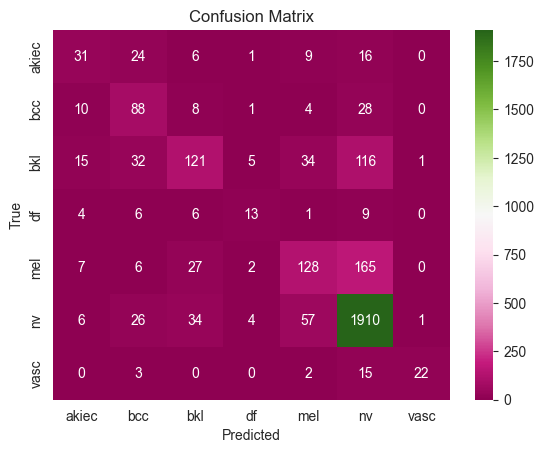

In [34]:
# Get the number_to_label_array so that we can use it later to plot the confusion matrix
complex_number_to_label_array = complex_testloader.dataset.dataset.number_to_label_array
# Test the model
test_net(complex_model, complex_testloader,complex_number_to_label_array, loss=complex_loss, device=device)

## Observations
- We can see again that the model has a strong inclination to predict the label `nv` , but this time not so much for `mel`
- The model predictions are mostly concentrated on the diagonal, (correct predictions), which is a VERY good thing
- There is also a huge improvement on `df`, the model actually predicted the label , and it did it correctly most of the time.
- Interestingly, for the `vasc` label, the model is not as good as the Simple model, precision is still good, but the recall is not as good as the Simple model

In [18]:
# Copying the lists so that I don't overwrite them
complex_train_loss = copy.deepcopy(train_loss)
complex_val_loss = copy.deepcopy(val_loss)
complex_train_accuracy = copy.deepcopy(train_accuracy)
complex_val_accuracy = copy.deepcopy(val_accuracy)

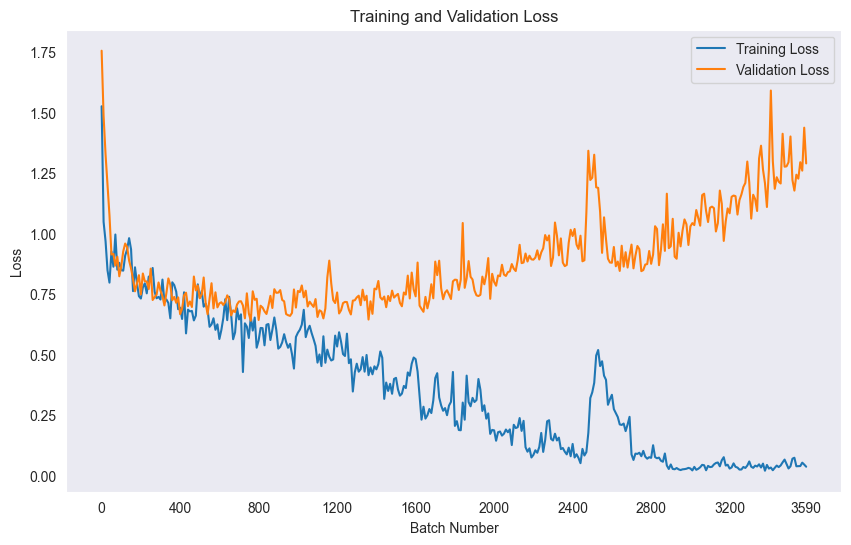

In [19]:
x_axis = list(map(lambda x:x*10,range(len(complex_train_loss))))
plt.figure(figsize=(10,6))
plt.plot(x_axis ,complex_train_loss, label='Training Loss')
plt.plot(x_axis , complex_val_loss,label='Validation Loss')
xticks = np.arange(x_axis[0], x_axis[-1]+1, 400.0)
plt.xticks([*xticks, x_axis[-1]])
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

## Observations
- We can see that the model starts to overfit at around 400-500 batches, as the validation loss starts to increase, while the training loss keeps decreasing
- We can see that the graph is less "jagged", which I think means that the model isn't overshooting the minimum loss, meaning the optimizer setting and choice are way better than the ones for the Simple model.
- There is a weird spike at 2400 batches, which I think might mean that the while the optimizer was steadily decreasing the loss, there was a sudden "hill" on the feature space.
-  This graph indicates that the model is doing two things better than the Simple model, it is not overshooting the minimum loss (the optimizer choice and settings are way better), and the model starts overfitting faster, which means that the model is learning faster.

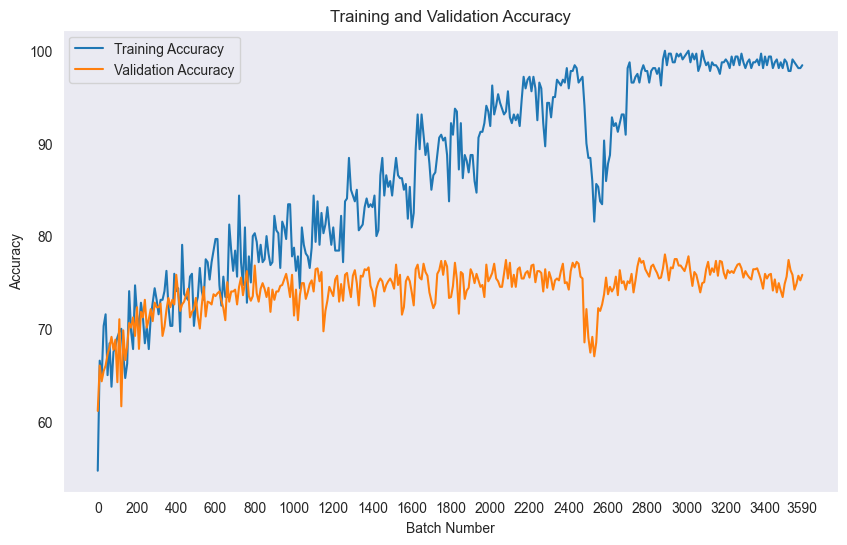

In [20]:
x_axis = list(map(lambda x:x*10,range(len(complex_train_accuracy))))
plt.figure(figsize=(10,6))
plt.plot(x_axis ,complex_train_accuracy, label='Training Accuracy')
plt.plot(x_axis , complex_val_accuracy,label='Validation Accuracy')
xticks = np.arange(x_axis[0], x_axis[-1]+1, 200.0)
plt.xticks([*xticks, x_axis[-1]])
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

## Observations
- In this graph the overfitting is really visible, because the validation accuracy is not decreasing, but it is not increasing either, while the training accuracy is increasing.
- This time it also less "jagged"
- and we can still see the same weird spike at 2400 batches

In [21]:
# I will also save the models so that I can load them later instead of training them again (takes a lot of time)
torch.save(model.state_dict(), 'results/model_states/simple_model.pth')
torch.save(complex_model.state_dict(), 'results/model_states/complex_model.pth')

# We don't need to save the dataloaders, because we use the same seed every time
# so the train, validation and test sets will be the same (seed = 42)
# But we do need to save the train, validation loss and accuracy
# so that we can plot them later without having to train the models again

torch.save(simple_train_loss, 'results/general/simple_train_loss.list.pyobj')
torch.save(simple_val_loss, 'results/general/simple_val_loss.list.pyobj')
torch.save(simple_train_accuracy, 'results/general/simple_train_accuracy.list.pyobj')
torch.save(simple_val_accuracy, 'results/general/simple_val_accuracy.list.pyobj')

torch.save(complex_train_loss, 'results/general/complex_train_loss.list.pyobj')
torch.save(complex_val_loss, 'results/general/complex_val_loss.list.pyobj')
torch.save(complex_train_accuracy, 'results/general/complex_train_accuracy.list.pyobj')
torch.save(complex_val_accuracy, 'results/general/complex_val_accuracy.list.pyobj')

# ResNet: Transfer Learning

In [22]:
import torchvision.transforms as transforms
# The transforms for the ResNet model are different from the ones for the Simple and Complex models
# create the transforms as given in the assignment
data_transforms = {
        'train': torchvision.transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225] )]),
        'val': torchvision.transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225] )])
        ,
    }

# Create the dataset
resnet_dataset = MLProject2Dataset(data_dir='data', metadata_fname='metadata.csv')

# To apply the different transforms to the train, validation and test sets
# We need to first split the dataset into train, validation and test to separate them as python objects
# and then apply the transforms to each one of them
# The split is train:val:test = 60%:10%:30% and because we use different transform for the train
# and validation/test sets, we need to split into train:val+test = 60%:40% and then split the val+test
resnet_train_dataset, resnet_val_test_dataset = torch.utils.data.random_split(resnet_dataset, [.6, .4],
                                                                         generator=torch.Generator().manual_seed(42)
                                                                              )
# Set the transforms for the train set
resnet_train_dataset.dataset.transform = data_transforms['train']
# Split the val+test set into val and test
# the split in the original dataset is 10%:30% when the total of the two is 40%
# now that the "total" of the two is 100%, the split is 25%:75% to get the correct split
resnet_val_dataset, resnet_test_dataset = torch.utils.data.random_split(resnet_val_test_dataset, [.25, .75],
                                                                        generator=torch.Generator().manual_seed(42)
                                                                        )

# Set the transforms for the val and test sets
# I don't really need to do the transform setting for both of them, because they are the same python object
# under the hood, but I do it for readability, and just in case that the implementation of the random_split
# changes in the future
resnet_val_dataset.dataset.transform = data_transforms['val']
resnet_test_dataset.dataset.transform = data_transforms['val']

# Create the dataloaders
BATCH_SIZE = 32
resnet_trainloader = DataLoader(resnet_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
resnet_valloader = DataLoader(resnet_val_dataset, batch_size=BATCH_SIZE, shuffle=True)
resnet_testloader = DataLoader(resnet_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Get the pretrained model
resnet_model = torchvision.models.resnet34(weights="DEFAULT")
resnet_model = resnet_model.to(device)
# Print the model summary
summary(resnet_model, (3, 224, 224))
# Create the optimizer
resnet_optimizer = optim.SGD(resnet_model.parameters(), lr=0.001,momentum=0.9)
# Create the loss function
resnet_loss = nn.CrossEntropyLoss()
# Train the model
train_net(resnet_model, resnet_trainloader,resnet_valloader,epochs=5, optimizer=resnet_optimizer,
          loss=resnet_loss, device=device)
# This cell took 17 minutes to run on my machine

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Test loss: 0.5500709414482117 | Test accuracy: 79.73% 


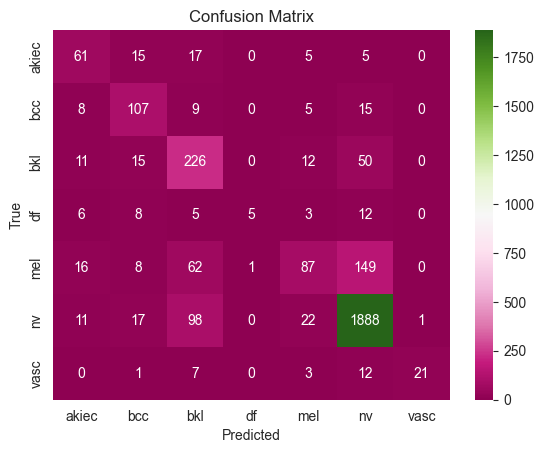

In [35]:
# Get the number_to_label_array so that we can use it later to plot the confusion matrix
resnet_number_to_label_array = resnet_testloader.dataset.dataset.dataset.number_to_label_array
# Test the model
test_net(resnet_model, resnet_testloader,resnet_number_to_label_array, loss=resnet_loss, device=device)

## Observations
- Way better performance than the Simple and Complex models, huge recall and precision for all labels
- The `bkl` label is now the biggest misclassification, for the `nv` label, which is weird in comparison to our previous results
- The precession on the `nv` label is WAY better than the Simple and Complex models, which is a good thing, because the `nv` label is the most common label in the dataset

In [24]:
# Copying the lists so that I don't overwrite them
resnet_train_loss = copy.deepcopy(train_loss)
resnet_val_loss = copy.deepcopy(val_loss)
resnet_train_accuracy = copy.deepcopy(train_accuracy)
resnet_val_accuracy = copy.deepcopy(val_accuracy)

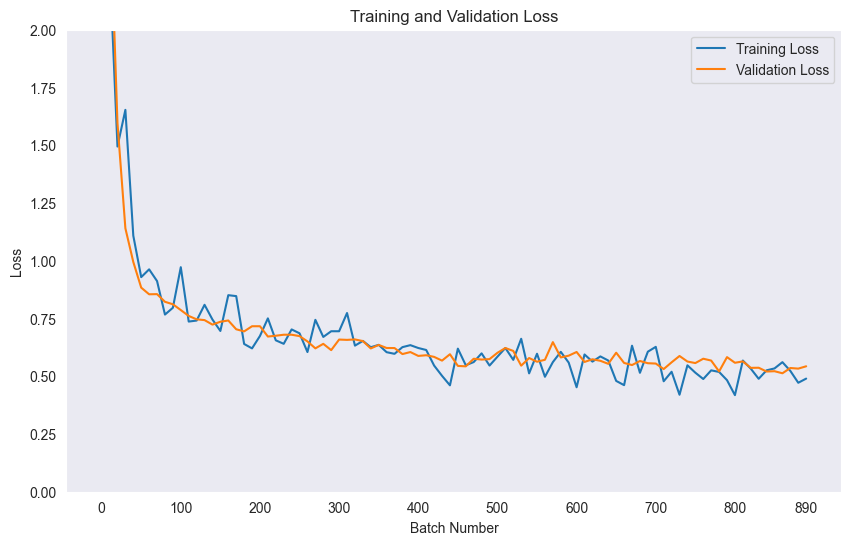

In [25]:
x_axis = list(map(lambda x:x*10,range(len(resnet_train_loss))))
plt.figure(figsize=(10,6))
plt.plot(x_axis ,resnet_train_loss, label='Training Loss')
plt.plot(x_axis , resnet_val_loss,label='Validation Loss')
xticks = np.arange(x_axis[0], x_axis[-1]+1, 100.0)
plt.xticks([*xticks, x_axis[-1]])
plt.ylim((0,2))
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

## Observations
- The model is WAY less "jagged", which could be the result of the optimizer choice and settings or because the number of batches is way less than the Simple and Complex models
- The validation and training curves are very close together, which is a good thing, because the model is improving on both sets
- The model doesn't overfit

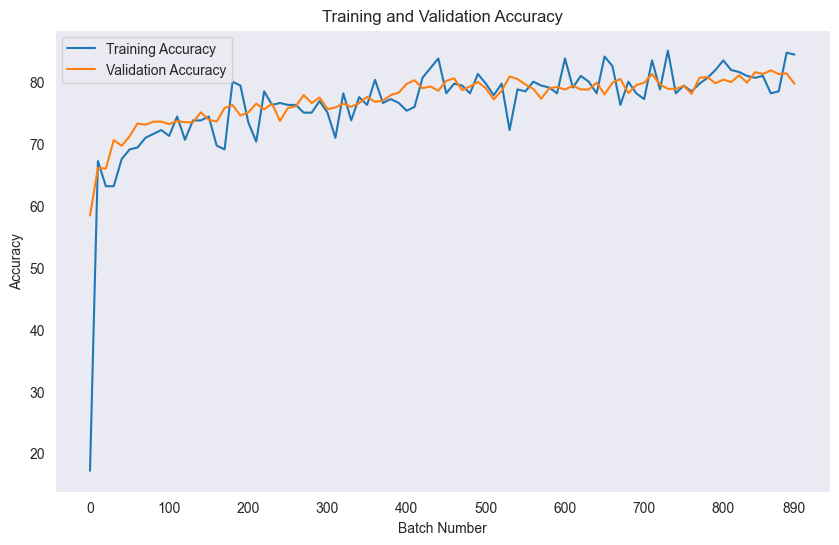

In [26]:
x_axis = list(map(lambda x:x*10,range(len(resnet_train_accuracy))))
plt.figure(figsize=(10,6))
plt.plot(x_axis ,resnet_train_accuracy, label='Training Accuracy')
plt.plot(x_axis , resnet_val_accuracy,label='Validation Accuracy')
xticks = np.arange(x_axis[0], x_axis[-1]+1, 100.0)
plt.xticks([*xticks, x_axis[-1]])
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

## Observations
- Again, less "jagged" than the Simple and Complex models
- The model doesn't overfit
- The validation and training curves are very close together, which is a good thing, because the model is improving on both sets
- and something we can see here better than on the loss plot, is that the performance is better than the Simple and Complex models